In [35]:
import gc 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from datetime import datetime
from typing import Union, List

from multiprocessing import Pool

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

from lightgbm import LGBMClassifier


%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/misha_beliy/opt/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
PATH_TO_DATA_FOLDER = "data/"
MOUNT_GDRIVE = False

# [Optional] Mount google drive for google colab

In [63]:
if MOUNT_GDRIVE:
    from google.colab import drive
    PATH_TO_DATA_FOLDER = "drive/MyDrive/4 курс/ML/HW-1/data/"
    drive.mount('/content/drive/')

# My implementation of RandomForestClassifier 

In [4]:
class MyRandomForestClassifier:
    _base_model_class = DecisionTreeClassifier
    
    _default_base_model_params = {
        "criterion": 'gini', 
        "max_depth": None, 
        "min_samples_split": 2, 
        "min_samples_leaf": 1, 
        "min_weight_fraction_leaf": 0.0, 
        "max_features": 'auto', 
        "max_leaf_nodes": None, 
        "min_impurity_decrease": 0.0, 
        "min_impurity_split": None,
    }
    
    def __init__(
        self,
        n_estimators: int = 100,
        bootstrap: bool = True,
        random_state: Union[int, np.random.RandomState] = None,
        max_samples: int = None,
        base_model_params: dict = {},
        threads: int = None,
    ):
        self._n_estimators = n_estimators
        self._bootstrap = bootstrap
        self._random_state = random_state
        self._max_samples = max_samples
        self._base_model_params = {**self._default_base_model_params, **base_model_params}
        self._estimators: List[self._base_model_class] = []
        self._data: pd.DataFrame = None
        self._threads = threads
        
    def fit(self, x: pd.DataFrame, y: pd.Series):
        self._set_random_state()
        data = x.copy()
        data["target"] = y
        self._data = data
        if self._threads:
            with Pool(self._threads) as pool:
                self._estimators = pool.map(self._fit_one, range(self._n_estimators))
        else:
            self._estimators = [self._fit_one(i) for i in range(self._n_estimators)]
    
    def predict(self, x: pd.DataFrame) -> np.array:
        proba = self.predict_proba(x)
        predicted = proba.argmax(axis=1)
        return predicted
        
    
    def predict_proba(self, x: pd.DataFrame) -> np.ndarray:
        probas = self._predict_probas(x)
        proba = 0
        for predicted in probas:
            proba += predicted
        proba /= len(probas)
        return proba
    
    def _predict_probas(self, x: pd.DataFrame) -> list:
        if self._threads:
            with Pool(self._threads) as pool:
                probas = pool.starmap(
                    self._predict_one_proba, 
                    [(i, x) for i in range(self._n_estimators)]
                )
        else:
            probas = [clf.predict_proba(x) for clf in self._estimators]
        
        return probas
    
    def _predict_one_proba(self, i: int, x: pd.DataFrame) -> np.ndarray:
        return self._estimators[i].predict_proba(x)
                        
    def _set_random_state(self) -> None:
        if self._random_state is None:
            return
        if isinstance(self._random_state, int):
            np.random.seed(self._random_state)
        elif isinstance(self._random_state, np.random.RandomState):
            np.random.set_state(self._random_state)
        else:
            raise ValueError(f"Invalid random state type: {type(self._random_state)}")
    
    def _fit_one(self, i: int = None) -> _base_model_class:
        classifier = self._base_model_class(**self._base_model_params)
        data = self._get_samples(self._data)
        x = data.drop(columns="target")
        classifier.fit(x, data["target"])
        return classifier
        
    
    def _get_samples(self, data: pd.DataFrame) -> pd.DataFrame:
        if not self._bootstrap:
            return data
        max_sample = self._max_samples
        if max_sample is None:
            max_sample = data.shape[0]
        elif isinstance(max_sample, float):
            max_sample = round(max_sample * data.shape[0])
        return data.sample(max_sample)

# Function to draw confusion matrix

In [5]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

# Read data

In [6]:
df = pd.read_csv(f"{PATH_TO_DATA_FOLDER}train.csv", index_col="id")
print("Shape:", df.shape)
df.head()

Shape: (957919, 119)


,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f110,f111,f112,f113,f114,f115,f116,f117,f118,claim
id,,,,,,,,,,,,,,,,,,,,,
0,0.10859,0.004314,-37.566,0.017364,0.28915,-10.25100,135.12,168900.0,3.992400e+14,86.489,...,-12.2280,1.7482,1.90960,-7.11570,4378.80,1.2096,8.613400e+14,140.1,1.01770,1
1,0.10090,0.299610,11822.000,0.276500,0.45970,-0.83733,1721.90,119810.0,3.874100e+15,9953.600,...,-56.7580,4.1684,0.34808,4.14200,913.23,1.2464,7.575100e+15,1861.0,0.28359,0
2,0.17803,-0.006980,907.270,0.272140,0.45948,0.17327,2298.00,360650.0,1.224500e+13,15827.000,...,-5.7688,1.2042,0.26290,8.13120,45119.00,1.1764,3.218100e+14,3838.2,0.40690,1
3,0.15236,0.007259,780.100,0.025179,0.51947,7.49140,112.51,259490.0,7.781400e+13,-36.837,...,-34.8580,2.0694,0.79631,-16.33600,4952.40,1.1784,4.533000e+12,4889.1,0.51486,1
4,0.11623,0.502900,-109.150,0.297910,0.34490,-0.40932,2538.90,65332.0,1.907200e+15,144.120,...,-13.6410,1.5298,1.14640,-0.43124,3856.50,1.4830,-8.991300e+12,NaN,0.23049,1


## Check NA

In [7]:
print("NA:")
pd.DataFrame(df.isna().sum())

NA:


,0
f1,15247
f2,15190
f3,15491
f4,15560
f5,15405
...,...
f115,15559
f116,15589
f117,15407
f118,15212


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 957919 entries, 0 to 957918
Columns: 119 entries, f1 to claim
dtypes: float64(118), int64(1)
memory usage: 877.0 MB


In [9]:
df.describe()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f110,f111,f112,f113,f114,f115,f116,f117,f118,claim
count,942672.000000,942729.000000,942428.000000,942359.000000,942514.000000,942398.000000,942415.000000,9.425460e+05,9.426700e+05,942696.000000,...,942554.000000,942420.000000,942509.000000,942686.000000,942481.000000,942360.000000,9.423300e+05,942512.000000,942707.000000,957919.000000
mean,0.090201,0.345964,4068.744207,0.201214,0.304869,-0.071458,1620.843815,3.771642e+05,1.806054e+15,5323.442367,...,-19.926398,2.074530,23.885245,1.748777,63152.973540,1.208876,4.276905e+16,3959.204669,0.559267,0.498492
std,0.043564,0.146251,6415.829440,0.212510,0.145343,2.123777,1276.281403,3.454325e+05,2.335204e+15,10068.380032,...,18.578439,0.895793,45.581360,10.088848,92435.016241,0.114959,6.732441e+16,3155.991777,0.408426,0.499998
min,-0.149910,-0.019044,-9421.700000,-0.082122,-0.006990,-12.791000,-224.800000,-2.984300e+04,-1.153300e+15,-26404.000000,...,-105.860000,0.277040,-27.691000,-26.589000,-81977.000000,0.905270,-8.944400e+15,-415.240000,-0.151240,0.000000
25%,0.070227,0.283050,418.430000,0.035086,0.240520,-1.120700,481.545000,9.120900e+04,1.153100e+13,75.876750,...,-28.812000,1.487700,-0.628880,-4.473975,2443.200000,1.146800,2.321100e+14,1306.200000,0.276560,0.000000
50%,0.090135,0.389100,1279.500000,0.137000,0.327790,-0.380110,1446.100000,2.896700e+05,5.043050e+14,1073.200000,...,-14.636000,1.662100,1.727700,0.885710,19479.000000,1.177200,1.327500e+16,3228.000000,0.473440,0.000000
75%,0.116500,0.458450,4444.400000,0.297100,0.412830,0.921940,2495.900000,5.605600e+05,3.103100e+15,5693.200000,...,-5.325300,2.522325,18.991000,6.840775,88488.000000,1.242000,5.278700e+16,6137.900000,0.746210,1.000000
max,0.415170,0.518990,39544.000000,1.319900,0.554750,11.202000,5426.600000,1.913700e+06,1.042400e+16,85622.000000,...,1.613400,4.565900,217.840000,47.757000,526050.000000,1.886700,3.249900e+17,13151.000000,2.743600,1.000000


# Feature engineering

In [10]:
def feature_engineering(df):
    df['missing_num'] = df.isnull().sum(axis=1)
    df['neg_num'] = (df < 0).sum(axis=1)
    df['missing_sign'] = (df['missing_num'] != 0).astype(int)

feature_engineering(df)

## Fill NA

In [11]:
df.fillna(df.mean(), inplace=True)
print("Shape:", df.shape)

Shape: (957919, 122)


In [12]:
def preprocess(df):
    feature_engineering(df)
    df.fillna(df.mean(), inplace=True)

# Drop NA

In [13]:
df.dropna(inplace=True)
df.shape

(957919, 122)

# Split train/test

In [14]:
y = df.claim
X = df.drop(columns="claim")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# For submission

In [38]:
def save_submission(indexes: np.array, submission: np.array, prefix: str = "", folder: str = "submissions/"):
    submit_df = pd.DataFrame({"id": indexes, "claim": submission})
    now = datetime.datetime.now()
    date_str = now.strftime("%m-%d-%Y_%H:%M:%S")
    file_name = f"{folder}{prefix}submission_{date_str}.csv"
    submit_df.to_csv(file_name, index=False)

# Read test data for submission

In [16]:
df_test = pd.read_csv(f"{PATH_TO_DATA_FOLDER}test.csv", index_col="id")
print("Shape:", df_test.shape)
preprocess(df_test)
df_test.head()

Shape: (493474, 118)


,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f112,f113,f114,f115,f116,f117,f118,missing_num,neg_num,missing_sign
id,,,,,,,,,,,,,,,,,,,,,
957919,0.165850,0.487050,1295.00,0.02310,0.31900,0.90188,573.29,3743.7,2.705700e+12,6221.000,...,0.430880,-10.7410,81606.0,1.1940,1.980400e+14,2017.1,0.46357,1,14,1
957920,0.129650,0.373480,1763.00,0.72884,0.33247,-1.26310,875.55,554370.0,5.955700e+14,934.430,...,-1.071200,11.8320,90114.0,1.1507,4.388000e+16,6638.9,0.28125,0,13,0
957921,0.120190,0.445210,736.26,0.04615,0.29605,0.31665,2659.50,317140.0,3.977800e+14,131.810,...,-1.931200,-3.2804,37739.0,1.1548,1.718100e+14,5844.0,0.13797,1,14,1
957922,0.054008,0.395960,996.14,0.85934,0.36678,-0.17060,386.56,325680.0,-3.432200e+13,-26.473,...,-0.011633,1.3840,26849.0,1.1490,2.138800e+17,6173.3,0.32910,0,19,0
957923,0.079947,-0.006919,10574.00,0.34845,0.45008,-1.84200,3027.00,428150.0,9.291500e+11,5999.400,...,0.757080,-4.9405,50336.0,1.2488,2.151300e+17,2250.1,0.33796,0,17,0


# Base tree model params

In [27]:
base_model_params = {
    "max_depth": 25,
    "min_samples_split": 5,
    "min_samples_leaf": 2
}

# Check time to train one tree

In [28]:
TRAIN_SAMPLES = 100000
X_train.shape[0]

641805

In [29]:
%%time
tree = DecisionTreeClassifier(**base_model_params)
tree.fit(X_train[:TRAIN_SAMPLES], y_train[:TRAIN_SAMPLES])

CPU times: user 23.8 s, sys: 223 ms, total: 24.1 s
Wall time: 24.1 s


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=25, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

# Train my implementation

In [30]:
%%time
my_clf = MyRandomForestClassifier(n_estimators=200, threads=5, base_model_params=base_model_params)
my_clf.fit(X_train[:TRAIN_SAMPLES], y_train[:TRAIN_SAMPLES])

CPU times: user 1.3 s, sys: 1.46 s, total: 2.76 s
Wall time: 1min 37s


In [31]:
%%time

my_clf_y_pred = my_clf.predict(X_test)

CPU times: user 9.13 s, sys: 16.3 s, total: 25.4 s
Wall time: 55 s


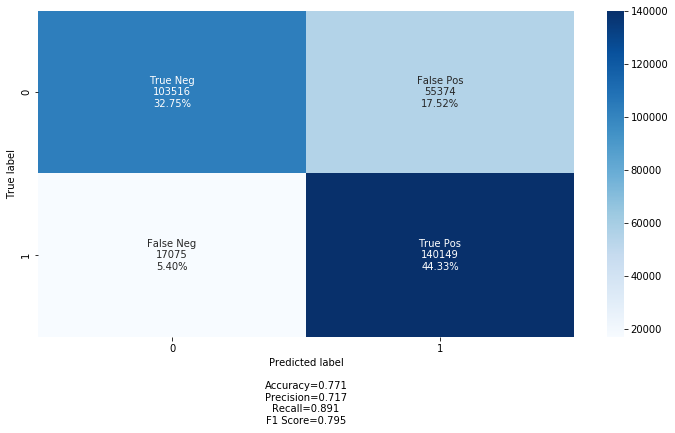

In [32]:
cf_matrix = confusion_matrix(y_test, my_clf_y_pred)
labels = ["True Neg", "False Pos", "False Neg", "True Pos"]
make_confusion_matrix(cf_matrix, figsize=(12, 6), group_names=labels)

### Submit MyRandomForestClassifier

In [40]:
%%time

submit_my_clf = my_clf.predict(df_test)
save_submission(df_test.index, submit_my_clf, prefix="my-clf_")

CPU times: user 12.2 s, sys: 19.2 s, total: 31.4 s
Wall time: 1min 5s


In [41]:
print("Private, public:", 0.77238, 0.77357)

Private, public: 0.77238 0.77357


# RandomForest

In [42]:
%%time

rfc_clf = RandomForestClassifier(n_jobs=4, **base_model_params)
rfc_clf.fit(X_train, y_train)

CPU times: user 21min 4s, sys: 8.99 s, total: 21min 13s
Wall time: 5min 21s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=25, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=4,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [43]:
rfc_feature_importance = pd.DataFrame({
        "Importance": rfc_clf.feature_importances_,
        "Feature": X_train.columns
      })
rfc_feature_importance.sort_values("Importance", ascending=False, inplace=True)
rfc_feature_importance.head(10)

,Importance,Feature
118,0.274673,missing_num
120,0.233308,missing_sign
2,0.004689,f3
34,0.004688,f35
33,0.004637,f34
39,0.004596,f40
7,0.004542,f8
95,0.004479,f96
46,0.004409,f47
64,0.004405,f65


Text(0, 0.5, 'Features')

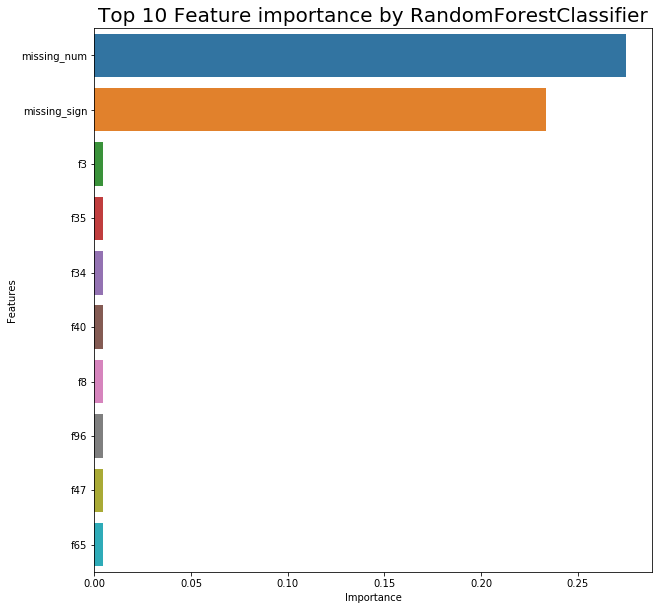

In [44]:
plt.figure(figsize=(10, 10))
feature_importance_graph = sns.barplot(y = rfc_feature_importance.Feature[:10], x = "Importance", data=rfc_feature_importance[:10], orient="h")
feature_importance_graph.set_title("Top 10 Feature importance by RandomForestClassifier", fontsize = 20)
feature_importance_graph.set_ylabel("Features")

In [45]:
y_rfc_pred = rfc_clf.predict(X_test)
accuracy_score(y_test, y_rfc_pred)

0.771484337928722

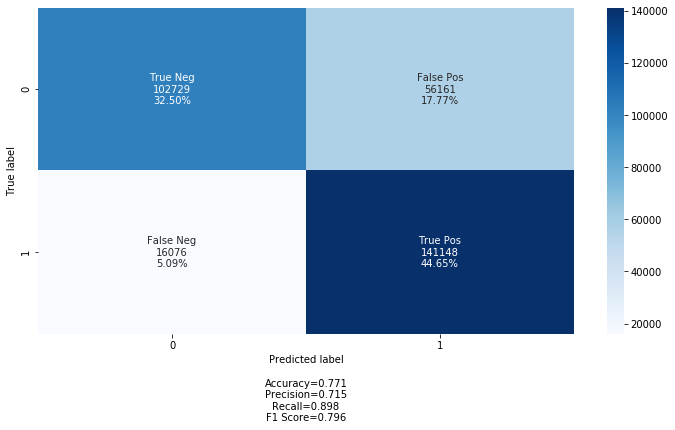

In [46]:
cf_matrix = confusion_matrix(y_test, y_rfc_pred)
labels = ["True Neg", "False Pos", "False Neg", "True Pos"]
make_confusion_matrix(cf_matrix, figsize=(12, 6), group_names=labels)

In [48]:
submit_rfc = rfc_clf.predict(df_test)
save_submission(df_test.index, submit_rfc, prefix="rfc_")

Private: 0.77236
Public: 0.77360

# LGBM

In [85]:
%%time

lgbc = LGBMClassifier(n_estimators=200, learning_rate=0.001)
lgbc.fit(X_train, y_train)

CPU times: user 5min 18s, sys: 3.9 s, total: 5min 22s
Wall time: 25 s


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.001, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=200, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [86]:
lgbc_feature_importance = pd.DataFrame({
        "Importance": lgbc.feature_importances_,
        "Feature": X_train.columns
      })
lgbc_feature_importance.sort_values("Importance", ascending=False, inplace=True)
lgbc_feature_importance.head(10)

,Importance,Feature
118,598,missing_num
20,523,f21
95,508,f96
34,471,f35
39,470,f40
33,431,f34
44,428,f45
69,319,f70
2,297,f3
64,259,f65


Text(0, 0.5, 'Features')

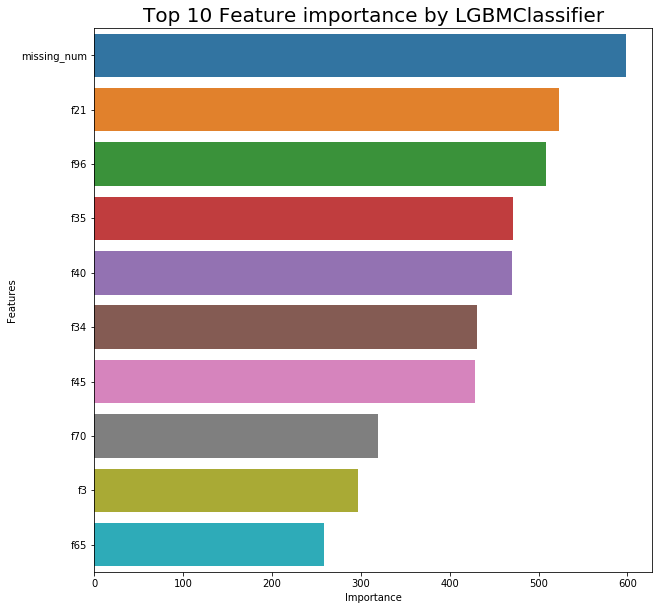

In [87]:
plt.figure(figsize=(10, 10))
feature_importance_graph = sns.barplot(y = lgbc_feature_importance.Feature[:10], x = "Importance", data=lgbc_feature_importance[:10], orient="h")
feature_importance_graph.set_title("Top 10 Feature importance by LGBMClassifier", fontsize = 20)
feature_importance_graph.set_ylabel("Features")

In [88]:
%%time

y_lgbc_pred = lgbc.predict(X_test)

CPU times: user 7.76 s, sys: 704 ms, total: 8.47 s
Wall time: 1.94 s


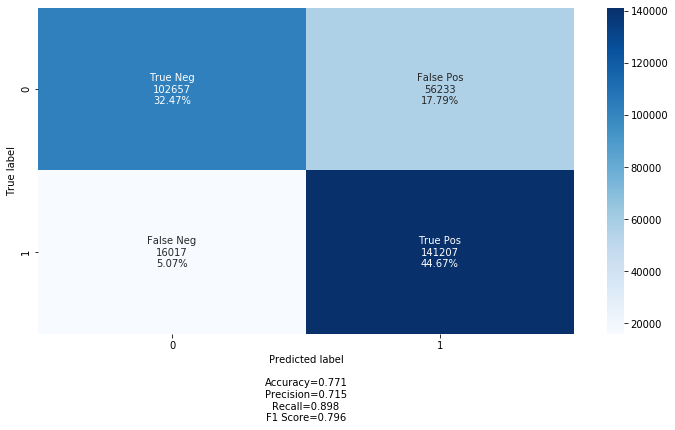

In [89]:
cf_matrix = confusion_matrix(y_test, y_lgbc_pred)
labels = ["True Neg", "False Pos", "False Neg", "True Pos"]
make_confusion_matrix(cf_matrix, figsize=(12, 6), group_names=labels)

In [90]:
%%time
submit_lgbc = lgbc.predict(df_test)
save_submission(df_test.index, submit_lgbc, prefix="lgbc_")

CPU times: user 13.7 s, sys: 1.39 s, total: 15.1 s
Wall time: 4 s


Private: 0.77238
Public 0.77357

# Bagging

In [55]:
def bagging_result(predicts: List[np.ndarray]) -> np.array:
    res = 0.0
    for i in predicts:
        res += i
    res /= len(predicts)
    ans = res.argmax(axis=1)
    return ans

## Bagging ckeck metrics

In [56]:
%%time

proba_test_my_clf = my_clf.predict_proba(X_test)
proba_test_rfc = rfc_clf.predict_proba(X_test)
proba_test_lgbc = lgbc.predict_proba(X_test)

y_begg_pred = bagging_result([proba_test_my_clf, proba_test_rfc, proba_test_lgbc])

CPU times: user 30.3 s, sys: 15.3 s, total: 45.6 s
Wall time: 53.4 s


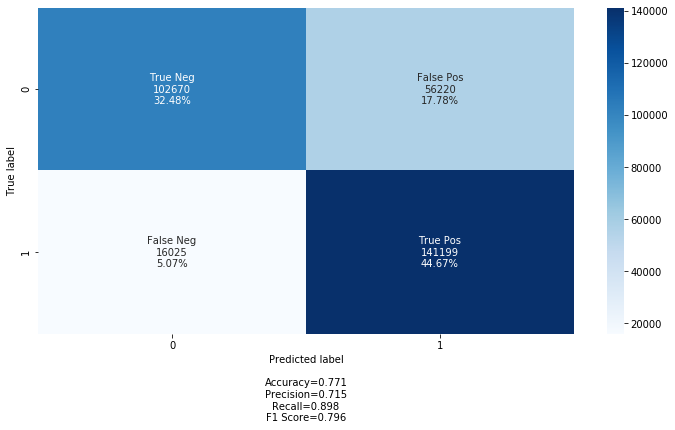

In [57]:
cf_matrix = confusion_matrix(y_test, y_begg_pred)
labels = ["True Neg", "False Pos", "False Neg", "True Pos"]
make_confusion_matrix(cf_matrix, figsize=(12, 6), group_names=labels)

In [58]:
%time

proba_my_clf = my_clf.predict_proba(df_test)
proba_rfc = rfc_clf.predict_proba(df_test)
proba_lgbc = lgbc.predict_proba(df_test)

CPU times: user 1 µs, sys: 1e+03 ns, total: 2 µs
Wall time: 4.05 µs


In [59]:
begg_res = bagging_result([proba_my_clf, proba_rfc, proba_lgbc])
begg_res

array([1, 0, 1, ..., 1, 0, 1])

In [60]:
diff_answer = (begg_res != submit_lgbc).sum()
diff_percent = round(diff_answer / submit_rfc.shape[0] * 100.0, 2)
print(f"Diff answer {diff_percent}%: {diff_answer}/{submit_rfc.shape[0]}")

Diff answer 0.01%: 33/493474


In [61]:
save_submission(df_test.index, begg_res, prefix="bagging_")

Private: 0.77239
Public: 0.77355

In [79]:
begg_res = bagging_result([proba_rfc, proba_lgbc])
diff_answer = (begg_res != submit_lgbc).sum()
diff_percent = round(diff_answer / submit_rfc.shape[0] * 100.0, 2)
print(f"Diff answer {diff_percent}%: {diff_answer}/{submit_rfc.shape[0]}")
save_submission(df_test.index, begg_res, prefix="bagging2_")

Diff answer 0.0%: 8/493474


Private: 0.77239
Public: 0.77358

In [80]:
begg_res = bagging_result([proba_my_clf, proba_lgbc])
diff_answer = (begg_res != submit_lgbc).sum()
diff_percent = round(diff_answer / submit_rfc.shape[0] * 100.0, 2)
print(f"Diff answer {diff_percent}%: {diff_answer}/{submit_rfc.shape[0]}")
save_submission(df_test.index, begg_res, prefix="bagging3_")

Diff answer 0.07%: 327/493474


Private: 0.77241
Public: 0.77356

# Analyse bagging results

In [74]:
predicts = pd.DataFrame({"y_true": y_test, "my": my_clf_y_pred, "rfc": y_rfc_pred, "lgbc": y_lgbc_pred})
columns = list(predicts)
for col in columns[1:]:
    predicts[f"{col}_is_true"] = predicts["y_true"] == predicts[col]
predicts

,y_true,my,rfc,lgbc,my_is_true,rfc_is_true,lgbc_is_true
id,,,,,,,
682721,0,1,1,1,False,False,False
470979,1,1,1,1,True,True,True
394613,1,1,1,1,True,True,True
329967,0,0,0,0,True,True,True
711757,0,0,0,0,True,True,True
...,...,...,...,...,...,...,...
443252,1,1,1,1,True,True,True
169305,0,1,1,1,False,False,False
953987,0,0,0,0,True,True,True


In [78]:
predicts[~predicts["my_is_true"] & predicts[["rfc_is_true", "lgbc_is_true"]].any(axis=1)]

,y_true,my,rfc,lgbc,my_is_true,rfc_is_true,lgbc_is_true
id,,,,,,,
153665,1,0,1,1,False,True,True
586692,1,0,1,1,False,True,True
202698,1,0,1,1,False,True,True
132062,1,0,1,1,False,True,True
49123,1,0,1,1,False,True,True
...,...,...,...,...,...,...,...
121586,1,0,1,1,False,True,True
350049,1,0,1,1,False,True,True
449272,1,0,1,1,False,True,True


In [83]:
predicts[~predicts["rfc_is_true"] & predicts[["my_is_true", "lgbc_is_true"]].any(axis=1)]

,y_true,my,rfc,lgbc,my_is_true,rfc_is_true,lgbc_is_true
id,,,,,,,
896669,0,0,1,1,True,False,False
556921,0,0,1,1,True,False,False
203078,0,0,1,1,True,False,False
496296,0,0,1,1,True,False,False
878289,0,0,1,1,True,False,False
...,...,...,...,...,...,...,...
442779,0,0,1,1,True,False,False
518783,0,0,1,1,True,False,False
944004,0,0,1,1,True,False,False


# The best combination of models is MyRandomClassifier with LBCClassifier
## (on private with 0.77241 score)

### Because when MyRandomClassifier make a mistake, LBCClassifier predict right